In [ ]:
obs_en1 = '/net3/bgr/Datasets/Argo/MLDs_v2/Argo_MLD.mld_pe_anomaly_25.nc'
ds_en1= xr.open_dataset(obs_en1)
MLD_argo=ds_en1
t_argo=MLD_argo.variables['Month']
MLD_argo = MLD_argo.assign_coords(Lon=((MLD_argo.Lon + 180) % 360 - 180))
MLD_argo = MLD_argo.sortby("Lon")
argo_lat=MLD_argo.variables['Lat']
argo_lon=MLD_argo.variables['Lon']
MLD_argo=MLD_argo.variables['MLD_median']
MLD_argo=xr.DataArray(MLD_argo, dims=["Month", "Lon", "Lat"],coords={'Month': t_argo.values,'Lon': argo_lon.values, 'Lat': argo_lat.values})


ds_obsdata = xr.Dataset()
ds_obsdata['lat']=MLD_argo['Lat'].values
ds_obsdata['lon']=MLD_argo['Lon'].values
ds_obsdata['Month']=MLD_argo['Month'].values
ds_obsdata['MLD_EN1']=(('Month','lon','lat'),MLD_argo.values)


ds_uncou=xr.open_dataset(pp_root_uncou+"/20040101_results/20040101.ocean_daily.nc")
MLD_uncou=ds_uncou['MLD_EN1'].groupby('time.month').median(dim='time')

MLD_uncou=xr.DataArray(MLD_uncou,dims=["month", "yh", "xh"],coords={'month':t_argo.values,'xh': model_grid_x, 'yh': model_grid_y})

ds_uncou_grid=xr.open_dataset(pp_root_uncou+"/20040101_results/20040101.ocean_static.nc")[['geolon_c','geolat_c','geolon_u','geolat_u','geolon_v','geolat_v','geolon','geolat']]
ds_modeldata=MLD_uncou
# ds_modeldata = ds_modeldata.groupby('time.month').mean('time')
static = ds_uncou_grid
Dims = [-100,-35,5,55]
Central = 0.5*(Dims[0]+Dims[1])
CLim1_min=[10,60]
CLim2_min=[-20,20]
CLim1_max=[10,500]
CLim2_max=[-100,100]

expName='NorthAtlantic Regional model'
Options = {
    'experiment name':expName,
    'Dims':Dims,
    'central':Central,
    'CLim1_min':CLim1_min,
    'CLim2_min':CLim2_min,
    'CLim1_max':CLim1_max,
    'CLim2_max':CLim2_max,
}
def Set_Plot_ds(cmn_lat,cmn_lon):
    #Using the obs to build the plotting grid
    #Can xarray handle periodic slicing domains?  I'm not sure so adjusting.
    ds_plot = xr.Dataset()
    ds_plot['lat'] = cmn_lat
    ds_plot['lon'] = cmn_lon
    
    return ds_plot

obs_lat = np.copy(ds_obsdata['lat'])
obs_lon = np.copy(ds_obsdata['lon'])
obs_lon[obs_lon<Options['Dims'][0]]+=360
obs_lon[obs_lon>Options['Dims'][1]]-=360
xi = np.argsort(obs_lon)
obs_lon_sort = obs_lon[xi]
lonlims = np.where((obs_lon_sort>Options['Dims'][0])&
                   (obs_lon_sort<Options['Dims'][1]))[0]
latlims = np.where((obs_lat>Options['Dims'][2])&
                   (obs_lat<Options['Dims'][3]))[0]
cmn_lat = obs_lat[latlims]
cmn_lon = obs_lon_sort[lonlims]

ds_min = Set_Plot_ds(cmn_lat,cmn_lon)
ds_max = Set_Plot_ds(cmn_lat,cmn_lon)
# print('ds_min',ds_min)
# print('ds_max',ds_max)

model = xr.Dataset()
model["yh"]=ds_modeldata.yh.values
model["xh"]=ds_modeldata.xh.values

model["MLD_min"]=(('yh','xh'),ds_modeldata.min(dim='month').values)
model["MLD_max"]=(('yh','xh'),ds_modeldata.max(dim='month').values)
model = model.assign_coords(lon=(('yh','xh'),ds_uncou_grid['geolon'].values))
model = model.assign_coords(lat=(('yh','xh'),ds_uncou_grid['geolat'].values))

# plt.figure()
# da_MLD_EN1_wave_ave=xr.DataArray(model["MLD_min"], dims=['yh', 'xh'], coords={'xh': model_grid_x, 'yh': model_grid_y})
# da_MLD_EN1_wave_ave.plot()
# plt.title('model min')
# plt.figure()
# da_MLD_EN1_wave_ave=xr.DataArray(model["MLD_max"], dims=['yh', 'xh'], coords={'xh': model_grid_x, 'yh': model_grid_y})
# da_MLD_EN1_wave_ave.plot()
# plt.title('model max')

# model = model.assign_coords(lon=(('yh','xh'), np.mod(ds_uncou_grid['geolon'].values + 180, 360) - 180))

obs = xr.Dataset()
obs['lat']=ds_obsdata['lat'].values
obs['lon']=ds_obsdata['lon'].values

obs["MLD_min"]=(('lat','lon'),ds_obsdata.MLD_EN1.min(dim='Month',skipna=False).values.T)
obs["MLD_max"]=(('lat','lon'),ds_obsdata.MLD_EN1.max(dim='Month',skipna=False).values.T)

# plt.figure()
# da_MLD_EN1_wave_ave=xr.DataArray(obs["MLD_min"], dims=['lat', 'lon'], coords={'lon': obs['lon'], 'lat': obs['lat']})
# da_MLD_EN1_wave_ave.plot()
# plt.title('argo min')
# plt.figure()
# da_MLD_EN1_wave_ave=xr.DataArray(obs["MLD_max"], dims=['lat', 'lon'], coords={'lon': obs['lon'], 'lat': obs['lat']})
# da_MLD_EN1_wave_ave.plot()
# plt.title('argo max')


regridder_mod = xe.Regridder(model, ds_min, "bilinear")

ds_min['model'] = (('lat','lon'),regridder_mod(model.MLD_min.data))

ds_min['obs'] = (('lat','lon'),((ds_obsdata.MLD_EN1.min(dim='Month',skipna=False).values.T[:,xi])[latlims[0]:latlims[-1]+1,lonlims[0]:lonlims[-1]+1]))

ds_max['model'] = (('lat','lon'),regridder_mod(model.MLD_max.data))

ds_max['obs'] = (('lat','lon'),((ds_obsdata.MLD_EN1.max(dim='Month',skipna=False).values.T[:,xi])[latlims[0]:latlims[-1]+1,lonlims[0]:lonlims[-1]+1]))
 
# plt.figure()
# da_MLD_EN1_wave_ave=xr.DataArray(ds_min['model'], dims=['lat', 'lon'], coords={'lon': ds_min['lon'], 'lat': ds_min['lat']})
# da_MLD_EN1_wave_ave.plot()
# plt.title('ds_min model')

# plt.figure()
# da_MLD_EN1_wave_ave=xr.DataArray(ds_max['model'], dims=['lat', 'lon'], coords={'lon': ds_max['lon'], 'lat': ds_max['lat']})
# da_MLD_EN1_wave_ave.plot()
# plt.title('ds_max model')

# print('nan in regrided data',np.isnan(regridder_mod(model.MLD_min.data)).sum())  # Count NaNs in regridded data
# print('nan in model data',np.isnan(model.MLD_min.data).sum())  # Count NaNs in regridded data
# print(regridder_mod(model.MLD_min.data).shape)  # Check the shape
# print('Check model lon range',model.lon.min().values, model.lon.max().values)  # Check model lon range
# print('Check ds_minl lon range',ds_min.lon.min().values, ds_min.lon.max().values)  # Check ds_min lon range
# print(model.lat.min().values, model.lat.max().values)  # Check model lat range
# print(ds_min.lat.min().values, ds_min.lat.max().values)  # Check ds_min lat range

def ComputeStats(ds):
    plon,plat = np.meshgrid(ds.lon.values,ds.lat.values)
    Mask = ((np.isfinite(ds.model.values))&(np.isfinite(ds.obs.values))&
           (plon>Options['Dims'][0])&
           (plon<Options['Dims'][1])&
           (plat>Options['Dims'][2])&
           (plat<Options['Dims'][3])
          )
    diff = (ds.model - ds.obs).values
    ds['bias']=np.nansum((diff[Mask]*np.cos(plat[Mask]*np.pi/180.)).ravel())/np.nansum((np.cos(plat[Mask]*np.pi/180.)).ravel())
    ds['RMS'] =np.sqrt(np.nansum((diff[Mask]**2*np.cos(plat[Mask]*np.pi/180.)).ravel())/np.nansum((np.cos(plat[Mask]*np.pi/180.)).ravel()))
    ds['r2']  =np.corrcoef(ds.model.values[Mask].ravel(),ds.obs.values[Mask].ravel())[1,0]**2
    return ds
ds_min = ComputeStats(ds_min)
ds_max = ComputeStats(ds_max)

# print("Model Longitude Range:", model.lon.min().values, model.lon.max().values)
# print("Obs Longitude Range:", ds_obsdata.lon.min().values, ds_obsdata.lon.max().values)
for ds_plot,method in [[ds_min,'min'],
                       [ds_max,'max']
                      ]:
    cmap = copy.copy(plt.cm.viridis_r)
    cmap2 = copy.copy(plt.cm.PuOr)
    cmap.set_bad('gray')
    cmap2.set_bad('gray')
    levels = np.linspace(Options['CLim1_'+method][0],Options['CLim1_'+method][1],11);
    levels2 = np.linspace(Options['CLim2_'+method][0],Options['CLim2_'+method][1],11);
    
    F = plt.figure(figsize=(12, 6))
    lon = ds_plot['lon'].values
    lat = ds_plot['lat'].values
    mod = ds_plot['model'].values
    obs = ds_plot['obs'].values
    dif = mod-obs
    lon,lat = np.meshgrid(lon,lat)
                       
    #ax=F.add_axes([0.1,0.52,0.425,0.32],projection=ccrs.Robinson(central_longitude=Options['central']),facecolor='gray',)
    ax=F.add_axes([0.1,0.52,0.4,0.32])
    cb0 = ax.pcolormesh(lon,
                        lat,
                        mod,
                       shading="auto", 
                       #transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),)
    ax.set_title('Model')
    
    # ax=F.add_axes([0.5,0.52,0.425,0.32],projection=ccrs.Robinson(central_longitude=Options['central']),facecolor='gray')
    ax=F.add_axes([0.55,0.52,0.4,0.32])
    cb1 = ax.pcolormesh(lon,lat,obs,
                       shading="auto", 
                       #transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False),)
    ax.set_title('Argo')
    
    # ax=F.add_axes([0.1,0.1,0.425,0.32],projection=ccrs.Robinson(central_longitude=Options['central']),facecolor='gray')
    ax=F.add_axes([0.1,0.1,0.4,0.32])
    cb2 = ax.pcolormesh(lon,lat,dif,
                       shading="auto", 
                       #transform=ccrs.PlateCarree(),
                       cmap=cmap2,
                       norm = mpl.colors.BoundaryNorm(levels2, ncolors=cmap2.N, clip=False),)
    ax.set(title='Model - Argo')
    
    cax1 = F.add_axes([0.55, 0.35, 0.4, 0.02])
    cbar1 = plt.colorbar(cb1,cax=cax1,orientation='horizontal')
    cbar1.set_label('MLD [m]')
    cax2 = F.add_axes([0.55, 0.2, 0.4, 0.02])
    cbar2 = plt.colorbar(cb2,cax=cax2,orientation='horizontal')
    cbar2.set_label('MLD difference [m]')
    
    
    ax = F.add_axes([0.1,0.9,0.8,0.1])
    ax.axis('off')
    ax.set(xlim=(0,1),ylim=(0,1))
    FS=12
    ax.text(0.25,0.2,'Bias={:4.3f} m'.format(ds_plot['bias'].values),fontsize=FS,horizontalalignment='center')
    ax.text(0.5,0.2,'RMS={:4.3f} m'.format(ds_plot['RMS'].values),fontsize=FS,horizontalalignment='center')
    ax.text(0.75,0.2,'$r^2$={:4.3f}'.format(ds_plot['r2'].values),fontsize=FS,horizontalalignment='center')
    FS=16
    ax.text(0.5,0.8,Options['experiment name']+': Monthly median'+method,
            fontsize=FS,horizontalalignment='center')


    


In [13]:
ds_uncoudata.values

array([[[       nan,        nan,        nan, ...,  51.546463,
          51.491013,  50.629868],
        [       nan,        nan,        nan, ...,  52.154556,
          52.415176,  51.979267],
        [       nan,        nan,        nan, ...,  53.02241 ,
          53.56879 ,  53.06047 ],
        ...,
        [       nan,        nan,        nan, ..., 129.5307  ,
         133.72377 , 138.89272 ],
        [       nan,        nan,        nan, ..., 128.80437 ,
         134.28508 , 145.55797 ],
        [       nan,        nan,        nan, ..., 129.73756 ,
         135.33249 , 143.17734 ]],

       [[       nan,        nan,        nan, ...,  46.443764,
          45.89228 ,  44.169216],
        [       nan,        nan,        nan, ...,  48.91619 ,
          48.26565 ,  46.58511 ],
        [       nan,        nan,        nan, ...,  50.491142,
          49.808086,  48.9169  ],
        ...,
        [       nan,        nan,        nan, ..., 193.66408 ,
         193.27795 , 188.88698 ],
        [   

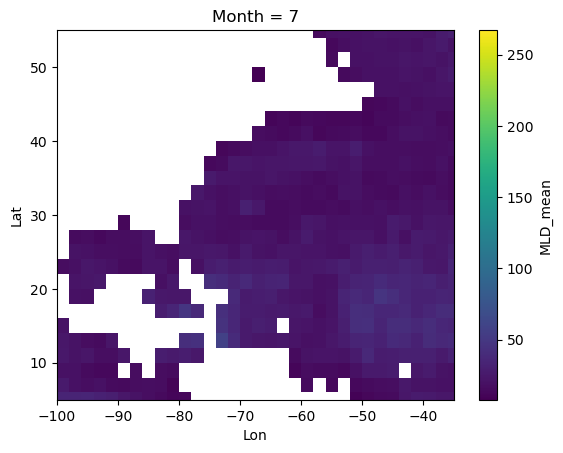

<xarray.DataArray '1/6_CT+LT' (time: 12, yh: 845, xh: 775)>
array([[[       nan,        nan,        nan, ...,  51.16966 ,
          51.449486,  50.09486 ],
        [       nan,        nan,        nan, ...,  52.028923,
          52.799988,  52.1118  ],
        [       nan,        nan,        nan, ...,  53.571373,
          54.289894,  54.000854],
        ...,
        [       nan,        nan,        nan, ..., 194.10759 ,
         196.48163 , 199.3209  ],
        [       nan,        nan,        nan, ..., 196.50388 ,
         197.86195 , 201.64856 ],
        [       nan,        nan,        nan, ..., 201.32315 ,
         202.64532 , 207.72462 ]],

       [[       nan,        nan,        nan, ...,  44.86757 ,
          44.96199 ,  44.99035 ],
        [       nan,        nan,        nan, ...,  48.602123,
          48.45842 ,  48.541912],
        [       nan,        nan,        nan, ...,  50.88374 ,
          50.83361 ,  50.937027],
...
        [       nan,        nan,        nan, ...,  79.314575,
          79.61107 ,  76.623924],
        [       nan,        nan,        nan, ...,  76.95095 ,
          79.57682 ,  78.33497 ],
        [       nan,        nan,        nan, ...,  77.07833 ,
          78.850266,  78.6679  ]],

       [[       nan,        nan,        nan, ...,  26.322996,
          26.659893,  25.62572 ],
        [       nan,        nan,        nan, ...,  24.81519 ,
          25.13443 ,  23.563242],
        [       nan,        nan,        nan, ...,  26.73831 ,
          26.775038,  25.251917],
        ...,
        [       nan,        nan,        nan, ..., 162.10971 ,
         159.58186 , 158.03745 ],
        [       nan,        nan,        nan, ..., 157.58698 ,
         155.14186 , 151.05025 ],
        [       nan,        nan,        nan, ..., 157.84238 ,
         158.20511 , 156.79683 ]]], dtype=float32)
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * xh       (xh) float64 -98.0 -97.92 -97.84 -97.76 ... -36.24 -36.16 -36.08
  * yh       (yh) float64 5.273 5.352 5.432 5.511 ... 51.88 51.9 51.91 51.93
Attributes:
    units:          m
    long_name:      Mixed layer depth (delta rho = 0.03)
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import xarray as xr
import os
import numpy as np
import logging
import cmocean
import copy

cmocean.cm.balance
cmap = copy.copy(cmocean.cm.balance)
cmap.set_bad('gray') 

###first verage every year and then concate
argo_root="/net3/bgr/Datasets/Argo/MLDs_v2/Argo_MLD.mld_pe_anomaly_25.nc"
pp_root_uncou = "/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/postProcessing/NWA12.COBALTuncou/"
pp_root_uncou_LAfalse="/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/postProcessing/NWA12.COBALTuncou_LALTFalse/"
pp_root_12_all="/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/c6/postProcessing/NWA12_wave_all/"
pp_root_12_wave="/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/c6/postProcessing/NWA12_wave/"
pp_root_6_all="/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/c6/postProcessing/NWA12_6_all/"
pp_root_6_wave="/archive/Qian.Xiao/Qian.Xiao/FMS_Wave_Coupling_ZC/c6/postProcessing/NWA12_6_wave/"
model_grid_x = xr.open_dataset(pp_root_uncou+"/20040101_results/20040101.ocean_daily.nc").variables['xh'] ##long -100 to -35 xh
model_grid_y = xr.open_dataset(pp_root_uncou+"/20040101_results/20040101.ocean_daily.nc").variables['yh'] ## latitude 5 to 55
time=xr.open_dataset(pp_root_uncou+"/20040101_results/20040101.ocean_month.nc").variables['time']

MLD_argo= xr.open_dataset(argo_root)
t_argo=MLD_argo.variables['Month']
MLD_argo = MLD_argo.assign_coords(Lon=((MLD_argo.Lon + 180) % 360 - 180))
MLD_argo = MLD_argo.sortby("Lon")
argo_lat=MLD_argo.variables['Lat']
argo_lon=MLD_argo.variables['Lon']
# MLD_uncou=xr.open_dataset(pp_root_uncou+"/20040101_results/20040101.ocean_daily.nc").variables['MLD_003_daily']
# MLD_uncou_LAfalse=xr.open_dataset(pp_root_uncou_LAfalse+"/20040101_results/20040101.ocean_daily.nc").variables['MLD_003_daily']
# MLD_6_all=xr.open_dataset(pp_root_6_all+"/20040101_results/20040101.ocean_daily.nc").variables['MLD_003_daily']
MLD_uncou=xr.open_dataset(pp_root_uncou+"/20040101_results/20040101.ocean_month.nc").variables['MLD_003_month']
MLD_uncou_LAfalse=xr.open_dataset(pp_root_uncou_LAfalse+"/20040101_results/20040101.ocean_month.nc").variables['MLD_003_month']
MLD_uncou=xr.DataArray(MLD_uncou,dims=["time", "yh", "xh"],coords={'time':t_argo.values,'xh': model_grid_x, 'yh': model_grid_y})
MLD_uncou_LAfalse=xr.DataArray(MLD_uncou_LAfalse,dims=["time", "yh", "xh"],coords={'time':t_argo.values,'xh': model_grid_x, 'yh': model_grid_y})
MLD_uncou.name = "uncou LT"
MLD_uncou_LAfalse.name = "uncou noLT"

MLD_6_all_1=xr.open_dataset(pp_root_6_all+"/20040101_results/20040101.ocean_month.nc").variables['MLD_003_month']
MLD_6_all_2=xr.open_dataset(pp_root_6_all+"/20040701_results/20040701.ocean_month.nc").variables['MLD_003_month']
MLD_6_all_1= xr.DataArray(MLD_6_all_1, dims=["time", "yh", "xh"])
MLD_6_all_2= xr.DataArray(MLD_6_all_2, dims=["time", "yh", "xh"])
MLD_6_all=xr.concat([MLD_6_all_1,MLD_6_all_2], dim='time')
MLD_6_all=xr.DataArray(MLD_6_all,coords={'time':t_argo.values,'xh': model_grid_x, 'yh': model_grid_y})
MLD_6_all.name = "1/6_CT+LT"

MLD_6_wave_1=xr.open_dataset(pp_root_6_wave+"/20040101_results/20040101.ocean_month.nc").variables['MLD_003_month']
MLD_6_wave_2=xr.open_dataset(pp_root_6_wave+"/20040701_results/20040701.ocean_month.nc").variables['MLD_003_month']
MLD_6_wave_1= xr.DataArray(MLD_6_wave_1, dims=["time", "yh", "xh"])
MLD_6_wave_2= xr.DataArray(MLD_6_wave_2, dims=["time", "yh", "xh"])
MLD_6_wave=xr.concat([MLD_6_wave_1,MLD_6_wave_2], dim='time')
MLD_6_wave=xr.DataArray(MLD_6_wave,coords={'time':t_argo.values,'xh': model_grid_x, 'yh': model_grid_y})
MLD_6_wave.name = "1/6_LT"

MLD_12_all_1=xr.open_dataset(pp_root_12_all+"/20040101_results/20040101.ocean_month.nc").variables['MLD_003_month']
MLD_12_all_2=xr.open_dataset(pp_root_12_all+"/20040701_results/20040701.ocean_month.nc").variables['MLD_003_month']
MLD_12_all_1= xr.DataArray(MLD_12_all_1, dims=["time", "yh", "xh"])
MLD_12_all_2= xr.DataArray(MLD_12_all_2, dims=["time", "yh", "xh"])
MLD_12_all=xr.concat([MLD_12_all_1,MLD_12_all_2], dim='time')
MLD_12_all=xr.DataArray(MLD_12_all,coords={'time':t_argo.values,'xh': model_grid_x, 'yh': model_grid_y})
MLD_12_all.name = "1/12_LT+CT"


MLD_12_wave_1=xr.open_dataset(pp_root_12_wave+"/20040101_results/20040101.ocean_month.nc").variables['MLD_003_month']
MLD_12_wave_2=xr.open_dataset(pp_root_12_wave+"/20040701_results/20040701.ocean_month.nc").variables['MLD_003_month']
MLD_12_wave_1= xr.DataArray(MLD_12_wave_1, dims=["time", "yh", "xh"])
MLD_12_wave_2= xr.DataArray(MLD_12_wave_2, dims=["time", "yh", "xh"])
MLD_12_wave=xr.concat([MLD_12_wave_1,MLD_12_wave_2], dim='time')
MLD_12_wave=xr.DataArray(MLD_12_wave,coords={'time':t_argo.values,'xh': model_grid_x, 'yh': model_grid_y})
MLD_12_wave.name = "1/12_LT"
##wave dimension[latitude(yh),longti(xh)]
##Argos[longti,lati]

##(long, latitu)
points = [
    (-90, 25),  # Central Gulf of Mexico
    (-85, 27),  # Near the Loop Current
    (-95, 23),  # Western Gulf of Mexico
    (-80, 15),  # Caribbean Sea (warm eddies)
    (-75, 18),  # South of Cuba (hurricane track)
    (-85, 20),  # Yucatán Channel
    (-75, 30),  # Offshore Florida (hurricane intensification)
    (-65, 35),  # Near the Gulf Stream
    (-60, 40),  # Storm transition zone
    (-95, 10),  # Eastern Caribbean
    (-50, 20),  # Mid-Atlantic region
    (-80, 45),  # Open ocean for storm interaction
    (-60, 50),  # Higher latitude hurricane tracks
    (-50, 32),  # Mid-ocean mixing region
    (-50, 43),
    (-60, 12)   # Southern Caribbean
]

plt.figure
MLD_argo['MLD_mean'][6, :, :].plot(x='Lon', y='Lat', cmap='viridis')
plt.xlim(-100, -35)
plt.ylim(5, 55)
plt.show()
MLD_argo=MLD_argo.variables['MLD_mean'].transpose('Month','Lat', 'Lon')
MLD_argo=xr.DataArray(MLD_argo, dims=["time", "yh", "xh"],coords={'time': t_argo.values,'xh': argo_lon.values, 'yh': argo_lat.values})
MLD_argo.name = "Argo"
MLD_6_all





In [42]:
MLD_argo

<xarray.DataArray (time: 12, yh: 86, xh: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * xh       (xh) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * yh       (yh) float64 -85.0 -83.0 -81.0 -79.0 -77.0 ... 79.0 81.0 83.0 85.0

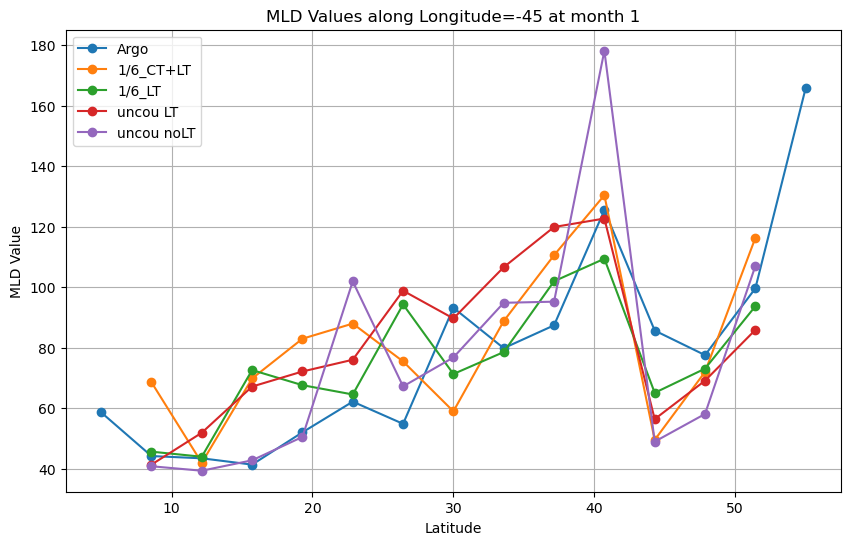

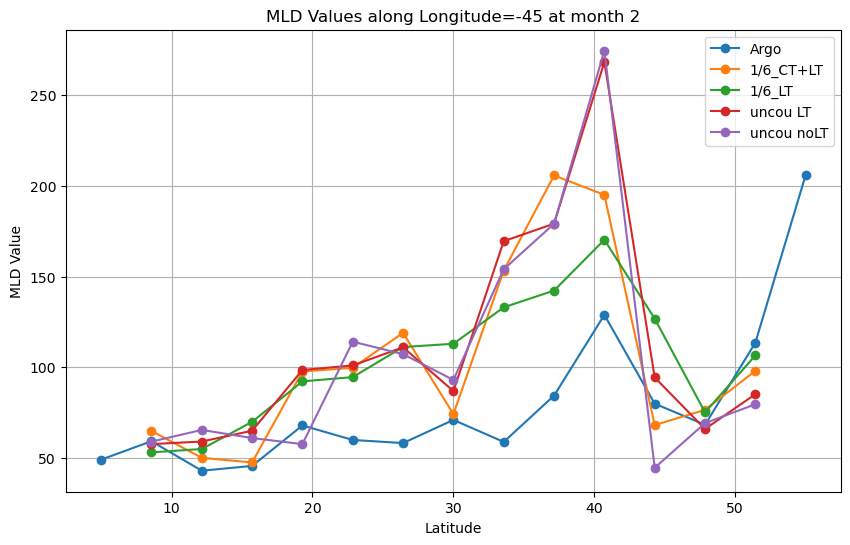

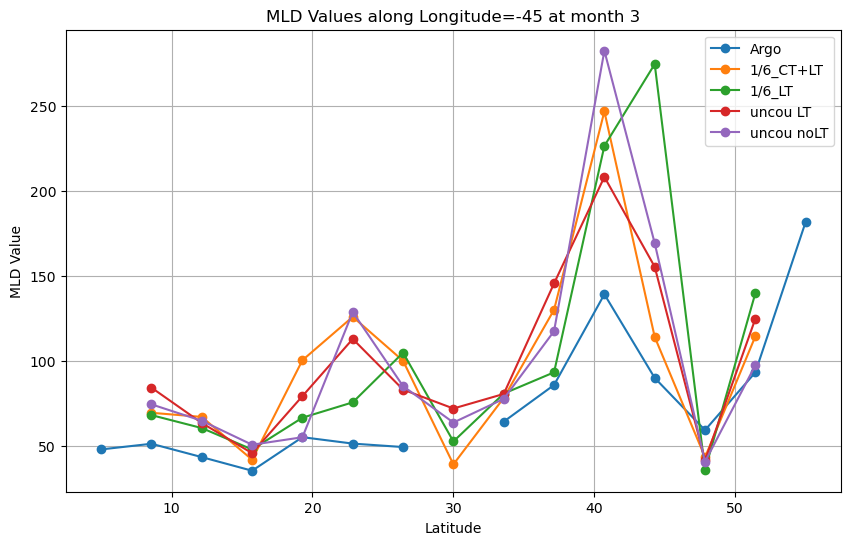

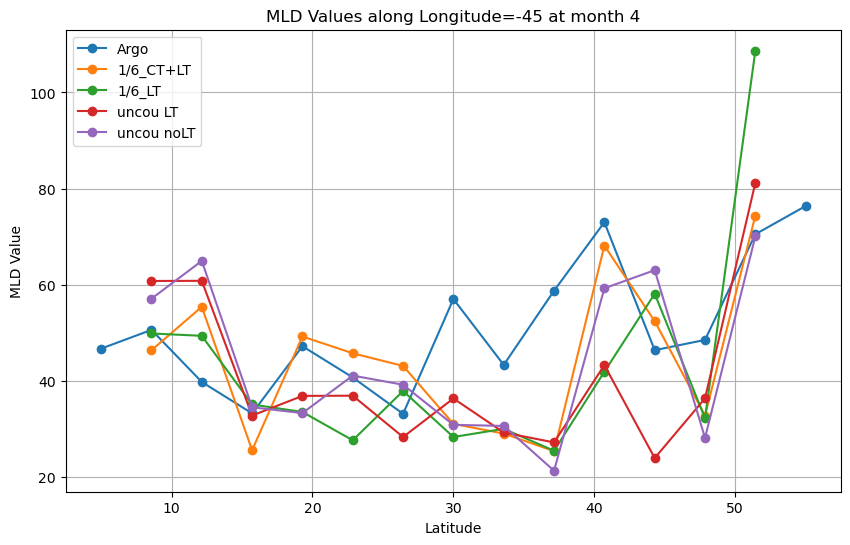

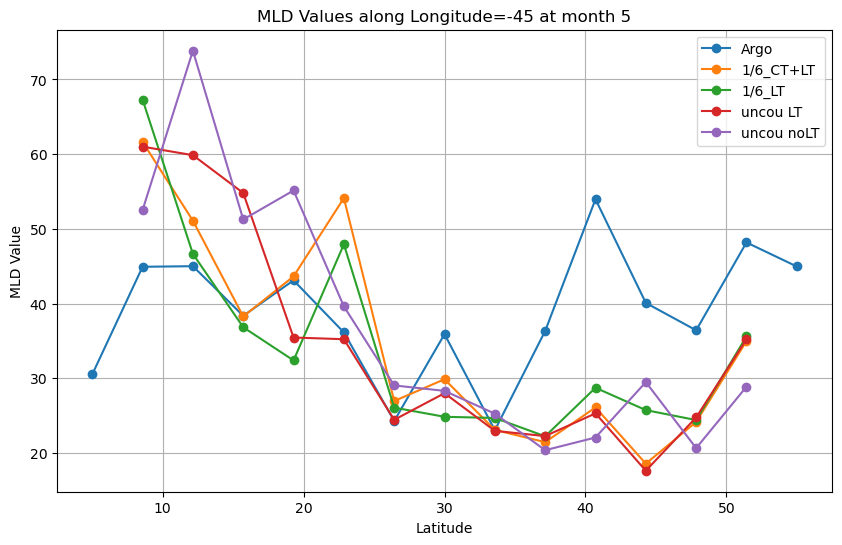

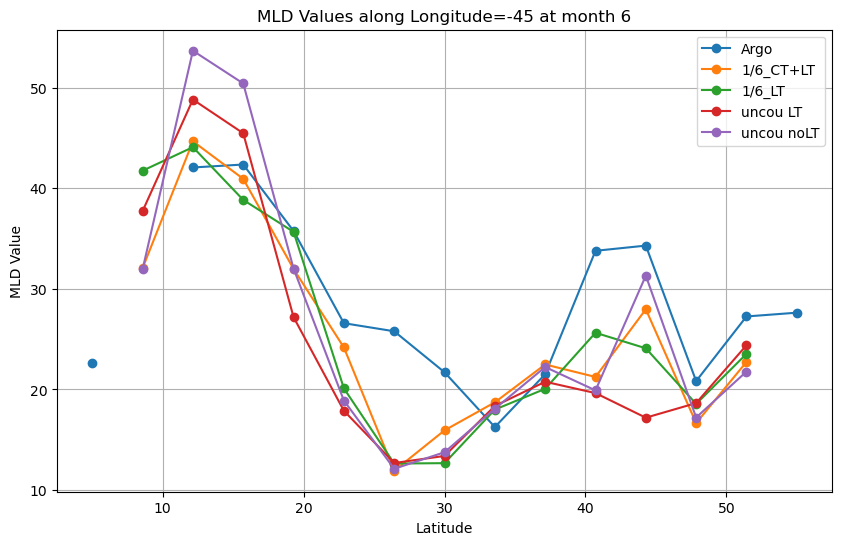

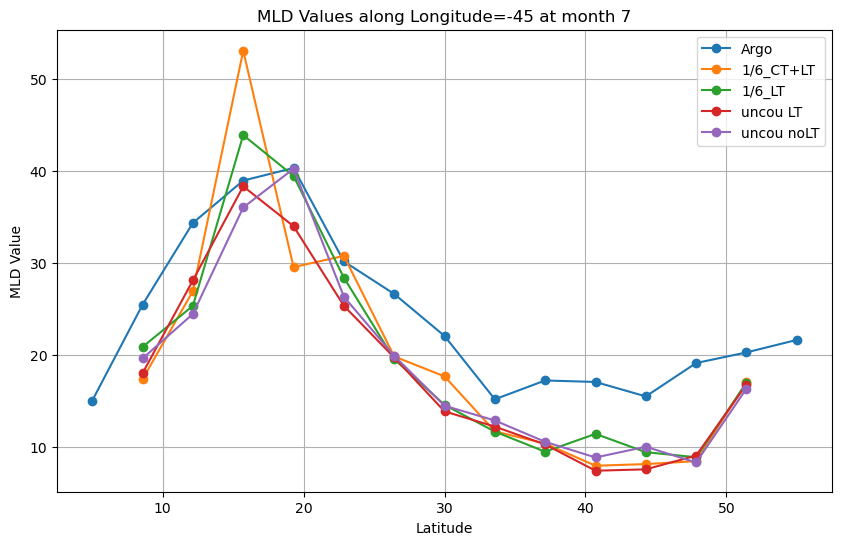

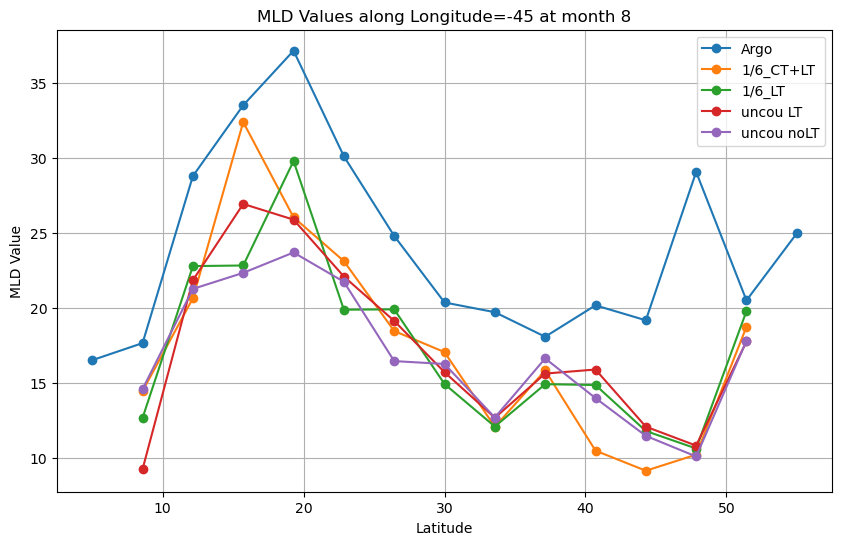

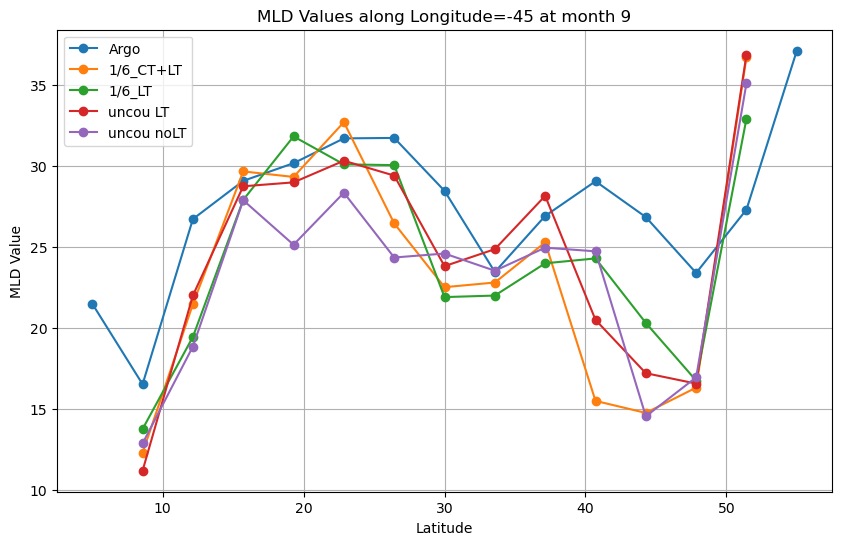

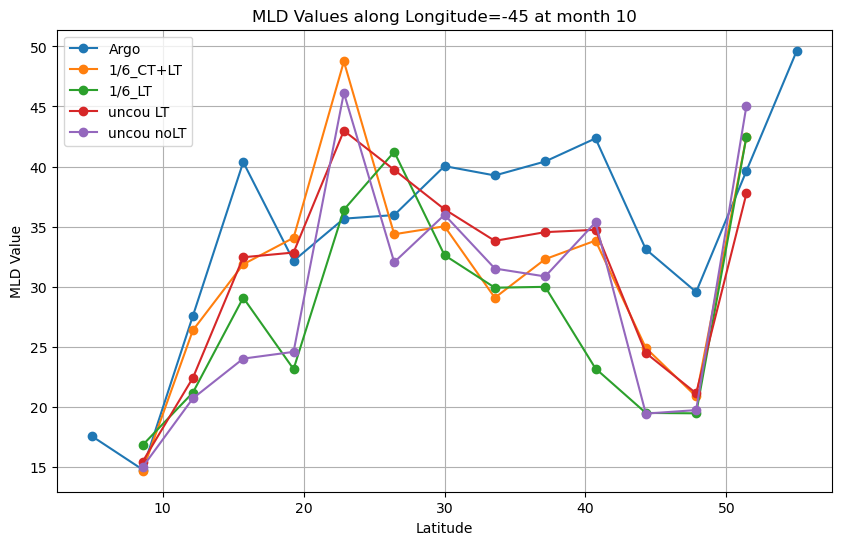

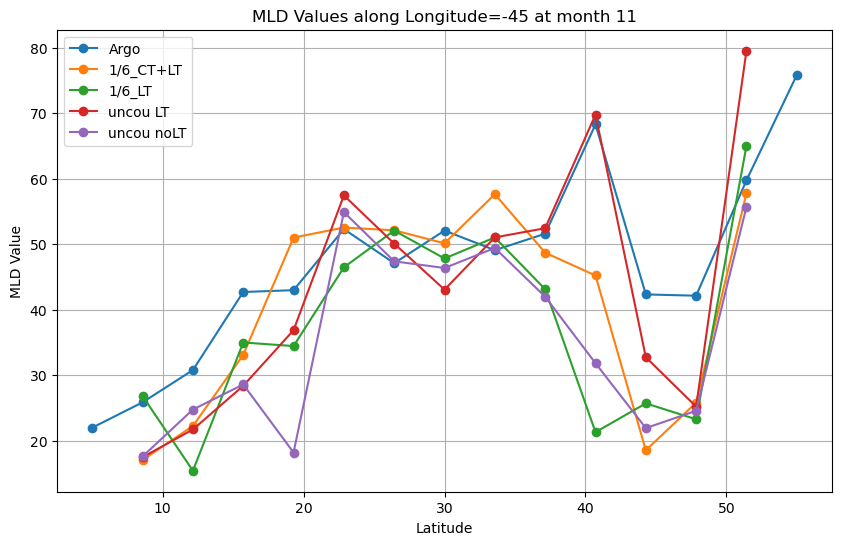

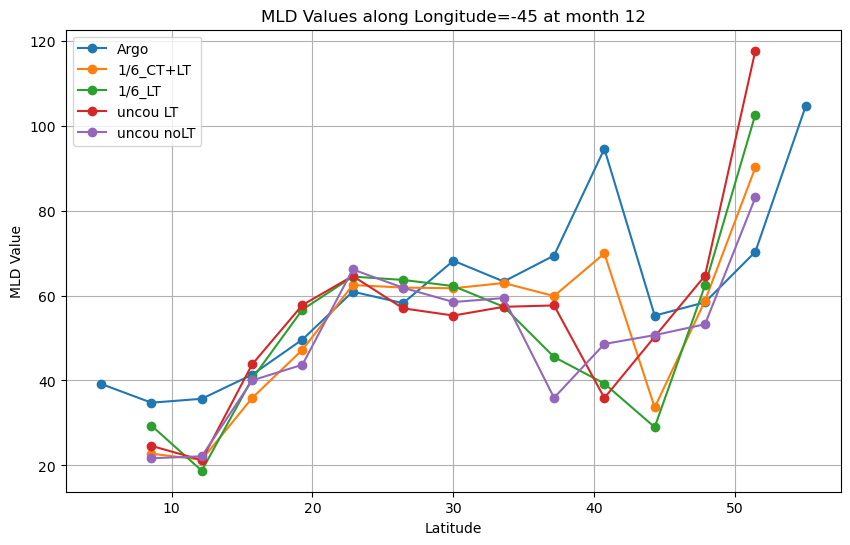

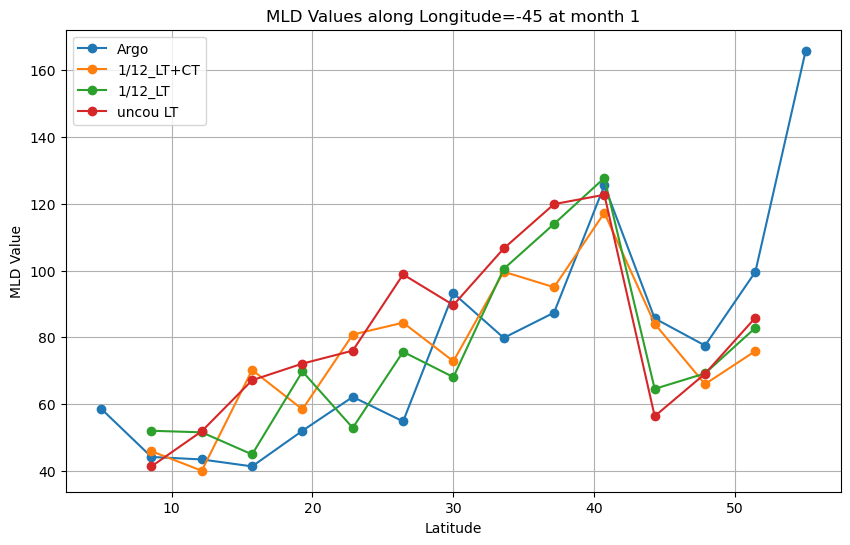

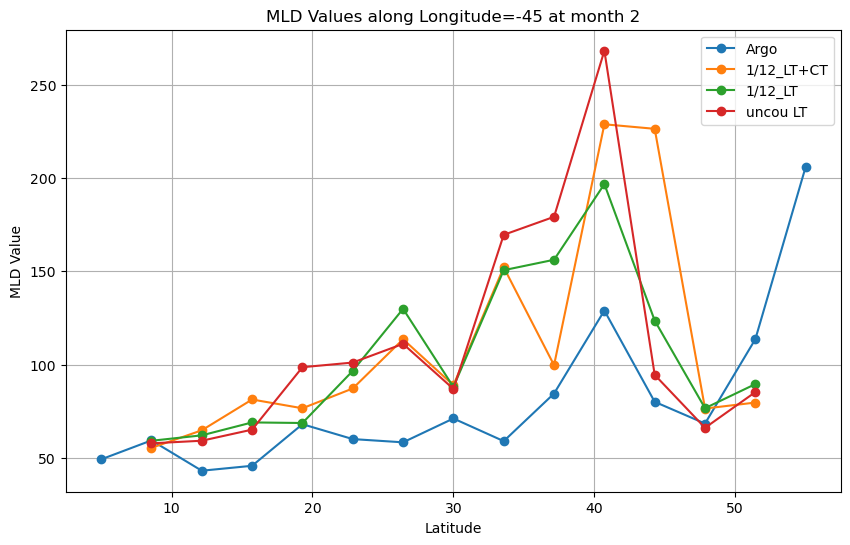

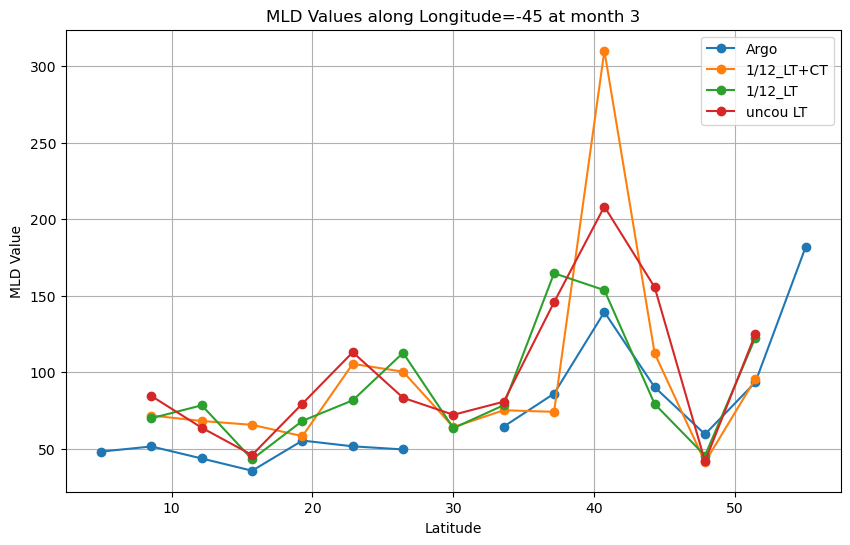

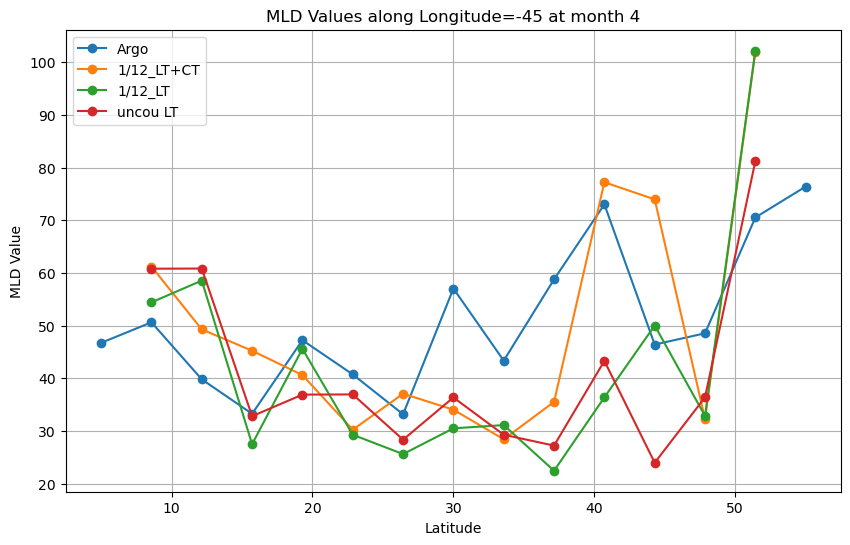

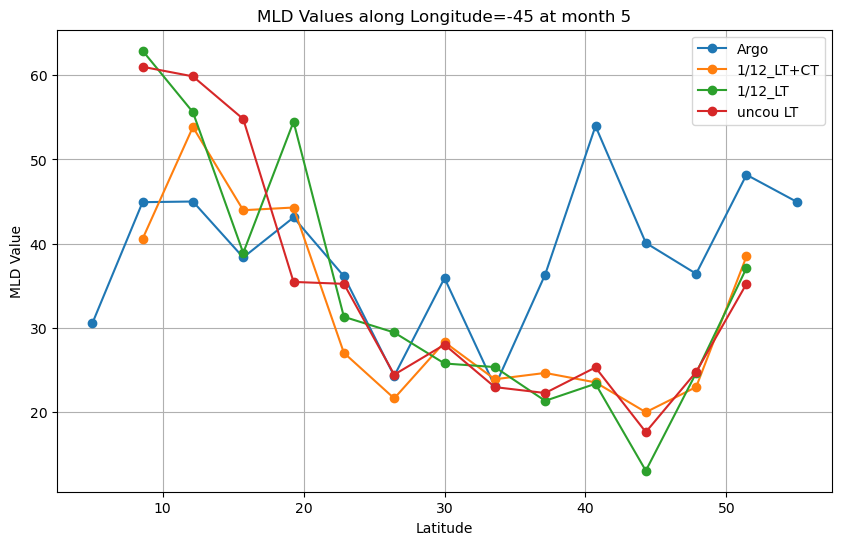

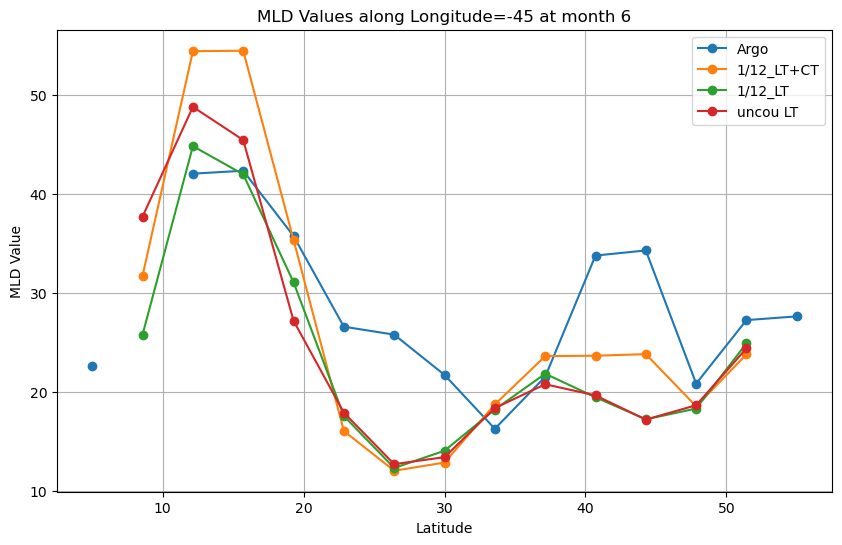

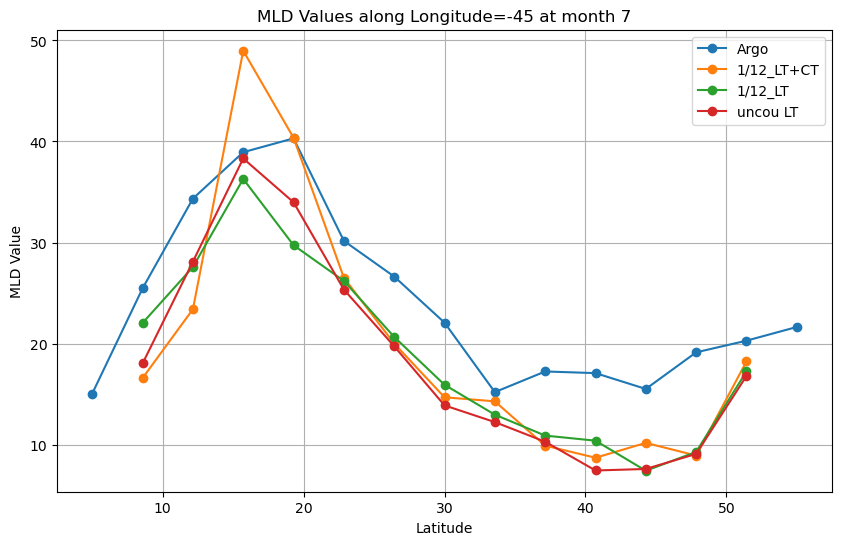

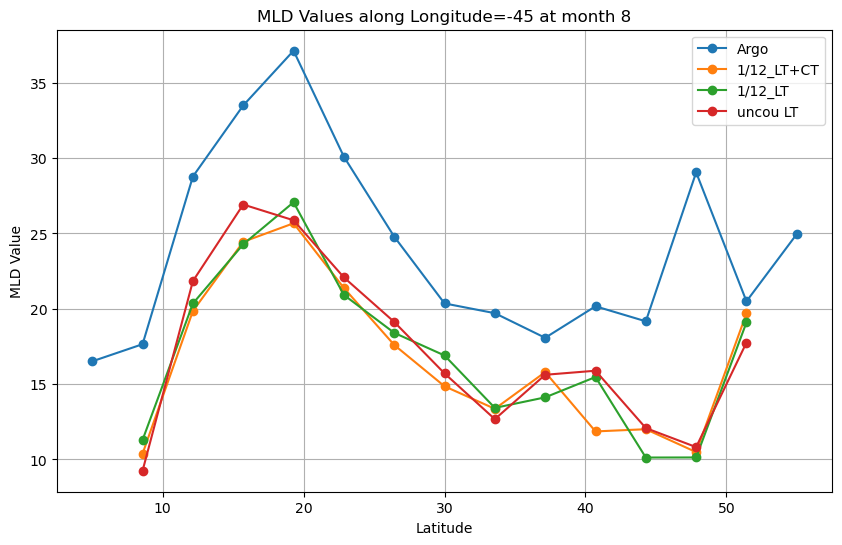

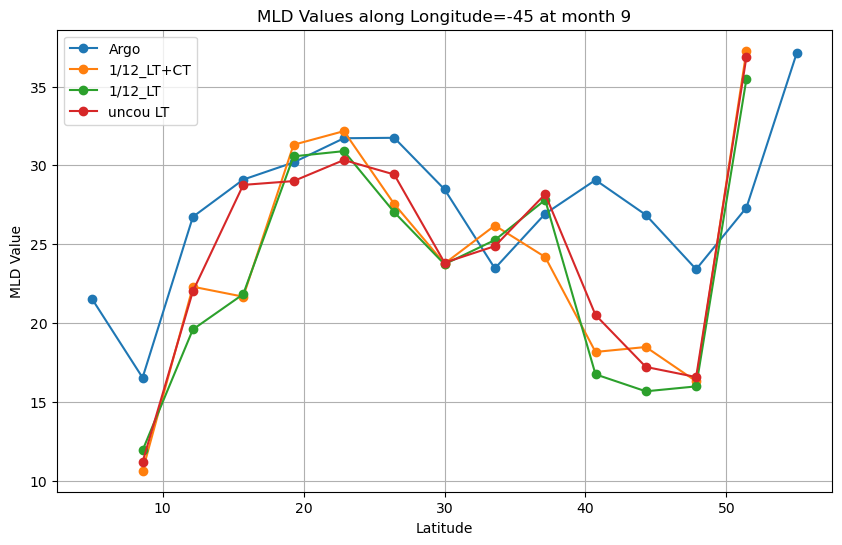

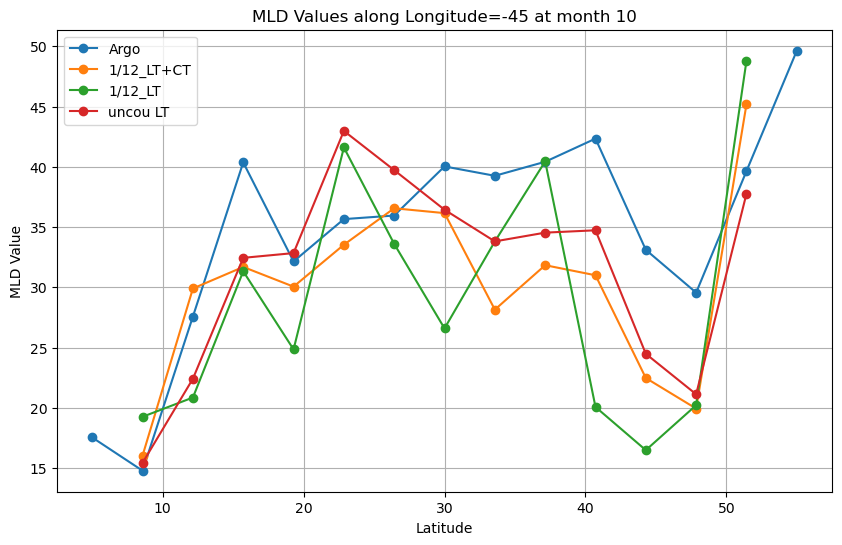

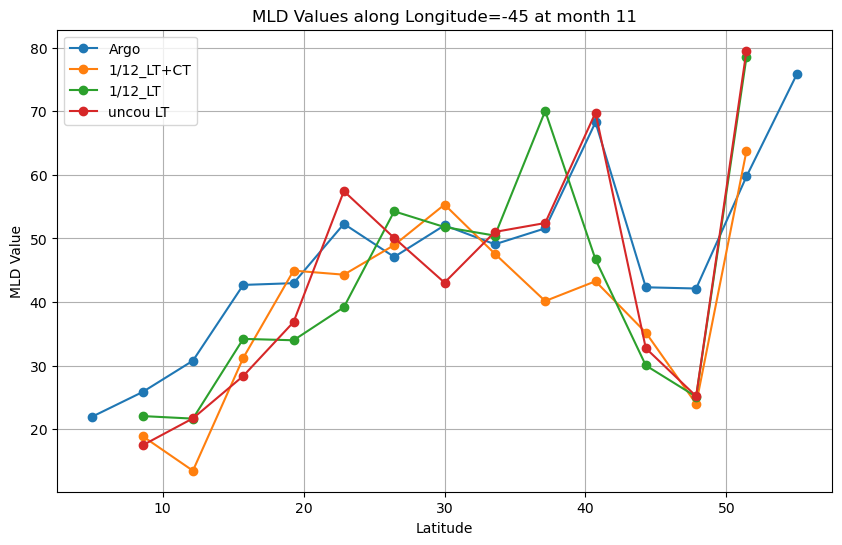

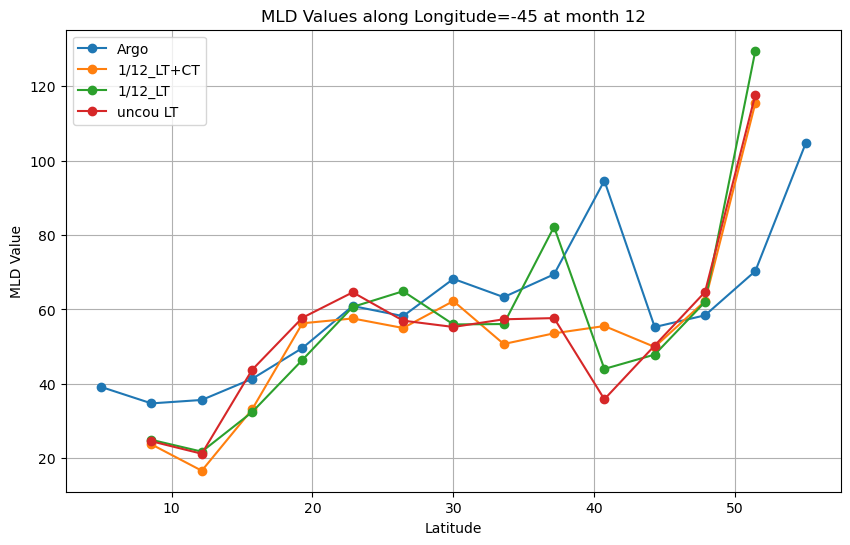

In [67]:
def plot_mld_for_points(datasets_list, points, t_argo):
    """
    Plot MLD values for given points along longitude=-45 for each dataset.

    Parameters:
    datasets_list (list): List of xarray datasets containing MLD data.
    points (array-like): List or array of tuples (longitude, latitude) for interpolation.
    t_argo (xarray.DataArray): Time dimension for the datasets.
    """
    # Extract longitude and latitude separately from points
    interp_lon = points[:, 0]  # Longitude is fixed
    interp_lat = points[:, 1]  # Latitude varies

    # Loop over time steps
    for i, t in enumerate(t_argo.values):
        plt.figure(figsize=(10, 6))

        # Loop over each dataset in datasets_list
        for dataset in datasets_list:
            # Select the MLD values for the specific time step
            mld = dataset.sel(time=t)

            # Interpolate MLD values at the given points (longitude = fixed and latitudes)
            interpolated_values = np.array([
                mld.interp(xh=lon, yh=lat, method="linear").values
                for lon, lat in zip(interp_lon, interp_lat)
            ])

            # Plot the MLD values against latitude for each dataset
            plt.plot(interp_lat, interpolated_values, label=str(dataset.name), marker='o')

        # Customize the plot
        plt.xlabel('Latitude')
        plt.ylabel('MLD Value')
        plt.title(f'MLD Values along Longitude=-45 at month {t}')
        plt.legend()  # Add legend to differentiate datasets
        plt.grid(True)
        plt.show()
points = np.array([(-45, lat) for lat in np.linspace(5, 55, 15)])
# Define datasets list
datasets_list = [MLD_argo, MLD_6_all, MLD_6_wave, MLD_uncou, 
                 MLD_uncou_LAfalse]
plot_mld_for_points(datasets_list, points, t_argo)

datasets_list = [MLD_argo, MLD_12_all, MLD_12_wave, MLD_uncou]
plot_mld_for_points(datasets_list, points, t_argo)

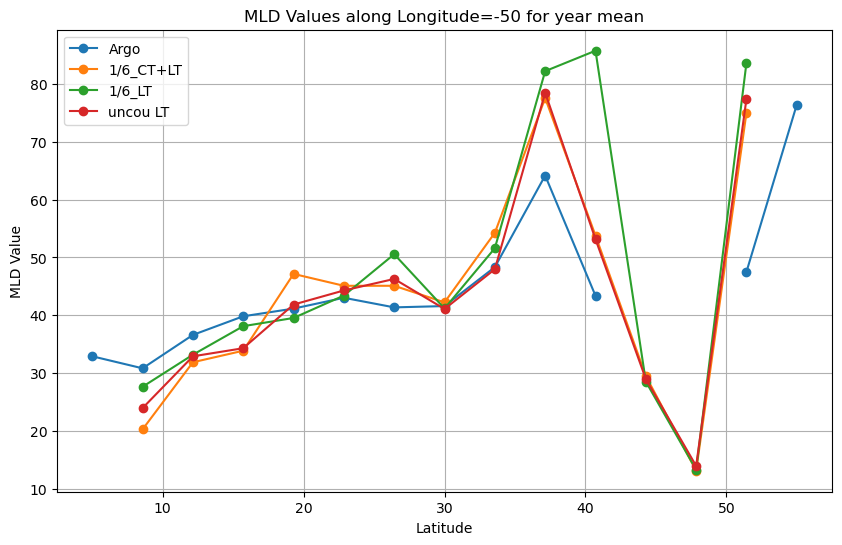

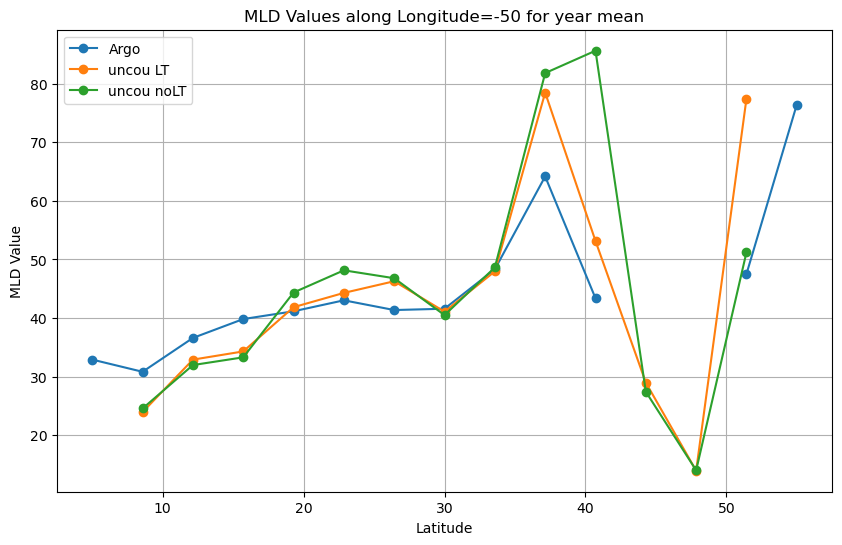

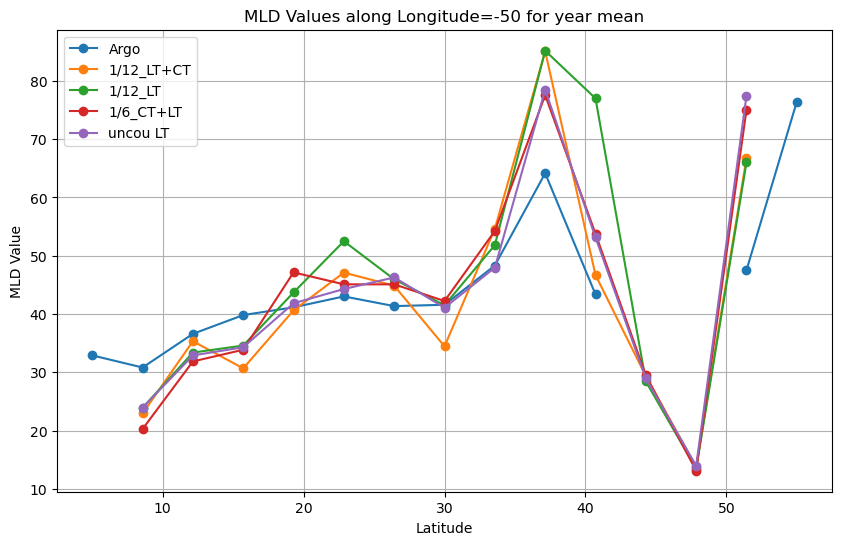

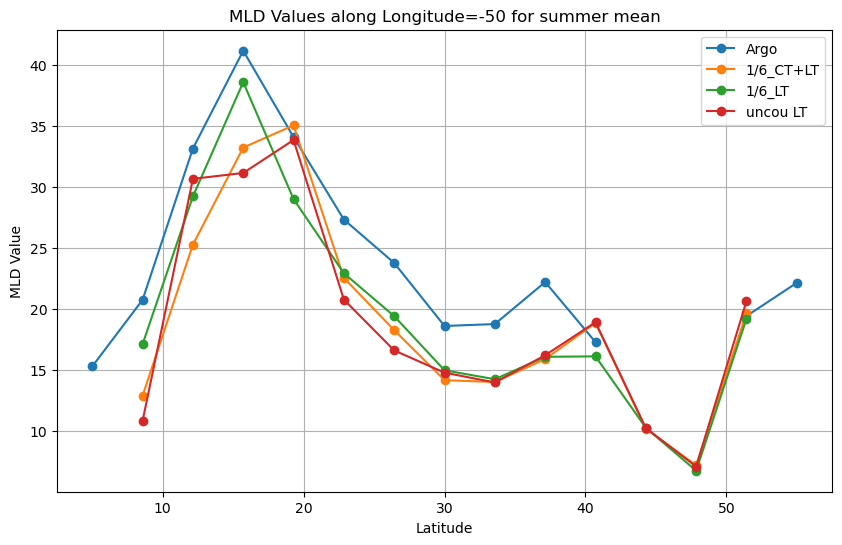

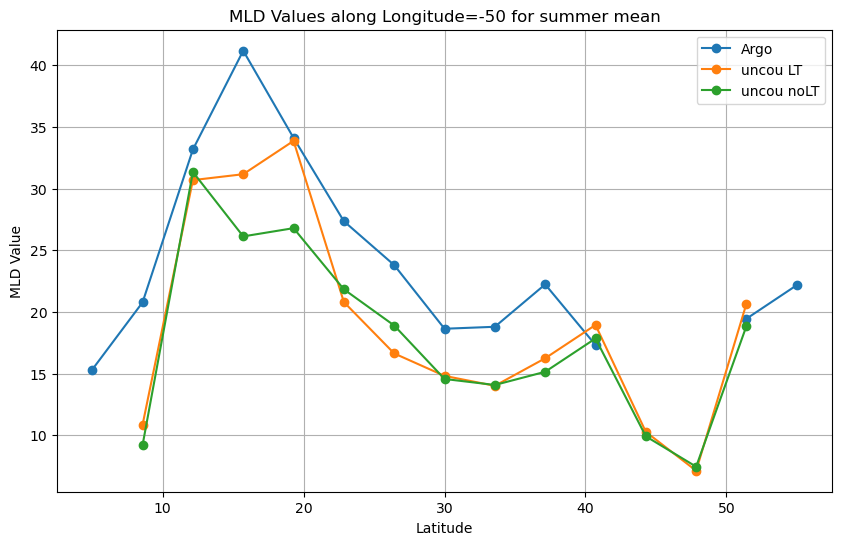

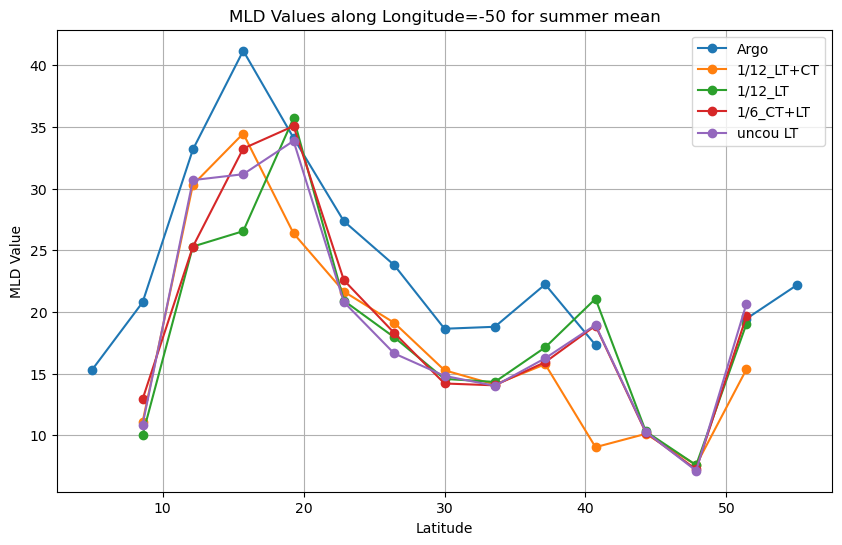

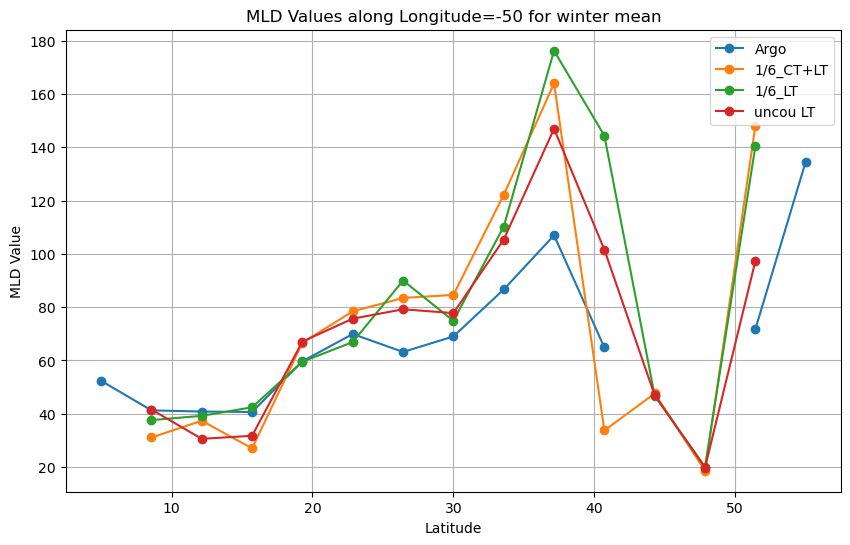

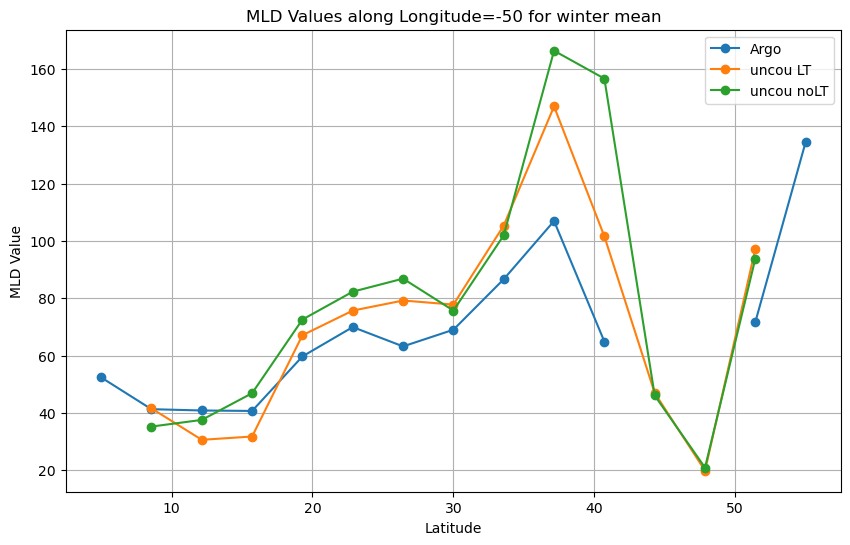

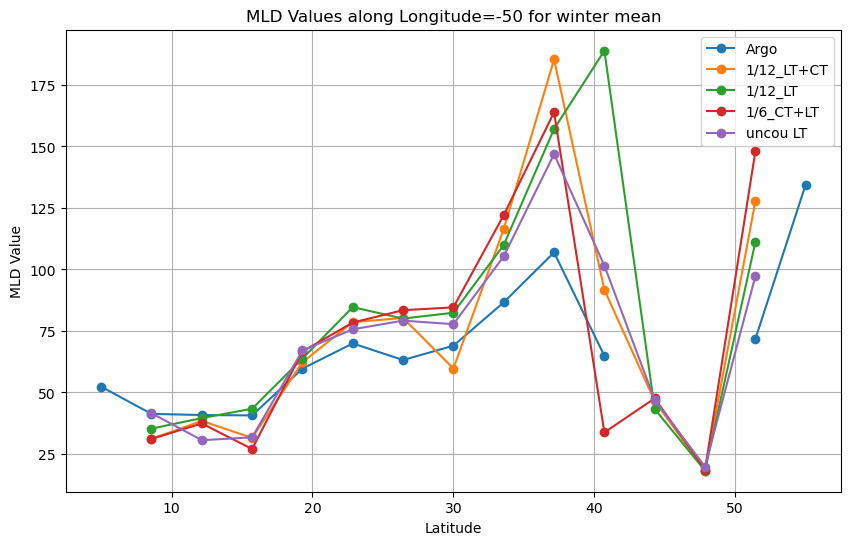

In [81]:
from scipy.interpolate import griddata
MLD_argo_ave=MLD_argo.mean('time')
MLD_6_all_ave=MLD_6_all.mean('time')
MLD_6_wave_ave=MLD_6_wave.mean('time')
MLD_12_all_ave=MLD_12_all.mean('time')
MLD_12_wave_ave=MLD_12_wave.mean('time')
MLD_uncou_ave=MLD_uncou.mean('time')
MLD_uncou_LAfalse_ave=MLD_uncou_LAfalse.mean('time')
def S_W (ds):
    summer = ds.sel(time=ds['time'].isin([6, 7, 8]))  # Filter for summer months (June, July, August)
    summer_mean = summer.mean(dim='time')
    winter = ds.sel(time=ds['time'].isin([12, 1, 2]))  # Filter for summer months (June, July, August)
    winter_mean = winter.mean(dim='time')
    return summer_mean,winter_mean
S_argo, W_argo=S_W(MLD_argo)
S_6_all, W_6_all=S_W(MLD_6_all)
S_6_wave, W_6_wave=S_W(MLD_6_wave)
S_12_all, W_12_all=S_W(MLD_12_all)
S_12_wave, W_12_wave=S_W(MLD_12_wave)
S_uncou, W_uncou=S_W(MLD_uncou)
S_uncou_LAfalse, W_uncou_LAfalse=S_W(MLD_uncou_LAfalse)


def plot_mld_for_points_ave(datasets_list, points,time_name,lon_slice):
    # Extract longitude and latitude separately
    interp_lon = points[:, 0]  # Longitudes
    interp_lat = points[:, 1]  # Latitudes
    
    # Loop over time steps
    
    plt.figure(figsize=(10, 6))
    
    for dataset in datasets_list:
        # Interpolate MLD values at given points
        mld = dataset
        interpolated_values = np.array([
            mld.interp(xh=lon, yh=lat, method="linear").values
            for lon, lat in zip(interp_lon, interp_lat)
        ])
        # Scatter plot of interpolated values
        plt.plot(interp_lat, interpolated_values, label=str(dataset.name), marker='o')
    
    # Customize the plot
    plt.xlabel('Latitude')
    plt.ylabel('MLD Value')
    plt.title(f'MLD Values along Longitude={lon_slice} for {time_name}')
    plt.legend()  # Add legend to differentiate datasets
    plt.grid(True)
    plt.show()

lon_slice=-50
points = np.array([(lon_slice, lat) for lat in np.linspace(5, 55, 15)])
# Define datasets list
# datasets_list = [MLD_argo_ave, MLD_6_all_ave, MLD_6_wave_ave, MLD_uncou_ave, 
#                  MLD_uncou_LAfalse_ave, MLD_12_all_ave, MLD_12_wave_ave]
datasets_list1 = [MLD_argo_ave, MLD_6_all_ave, MLD_6_wave_ave, MLD_uncou_ave]
datasets_list2= [MLD_argo_ave, MLD_uncou_ave,MLD_uncou_LAfalse_ave]
datasets_list3 = [MLD_argo_ave, MLD_12_all_ave, MLD_12_wave_ave, MLD_6_all_ave,MLD_uncou_ave]
plot_mld_for_points_ave(datasets_list1, points,'year mean',lon_slice)
plot_mld_for_points_ave(datasets_list2, points,'year mean',lon_slice)
plot_mld_for_points_ave(datasets_list3, points,'year mean',lon_slice)
datasets_list1 = [S_argo, S_6_all, S_6_wave, S_uncou]
datasets_list2= [S_argo, S_uncou,S_uncou_LAfalse]
datasets_list3 = [S_argo, S_12_all, S_12_wave, S_6_all,S_uncou]
plot_mld_for_points_ave(datasets_list1, points,'summer mean',lon_slice)
plot_mld_for_points_ave(datasets_list2, points,'summer mean',lon_slice)
plot_mld_for_points_ave(datasets_list3, points,'summer mean',lon_slice)
datasets_list1 = [W_argo, W_6_all, W_6_wave, W_uncou]
datasets_list2= [W_argo, W_uncou,W_uncou_LAfalse]
datasets_list3 = [W_argo, W_12_all, W_12_wave, W_6_all,W_uncou]
plot_mld_for_points_ave(datasets_list1, points,'winter mean',lon_slice)
plot_mld_for_points_ave(datasets_list2, points,'winter mean',lon_slice)
plot_mld_for_points_ave(datasets_list3, points,'winter mean',lon_slice)

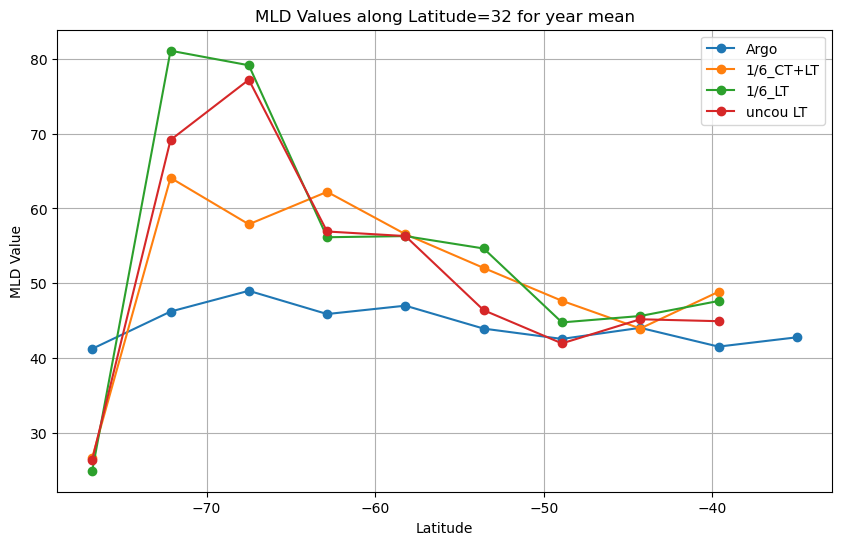

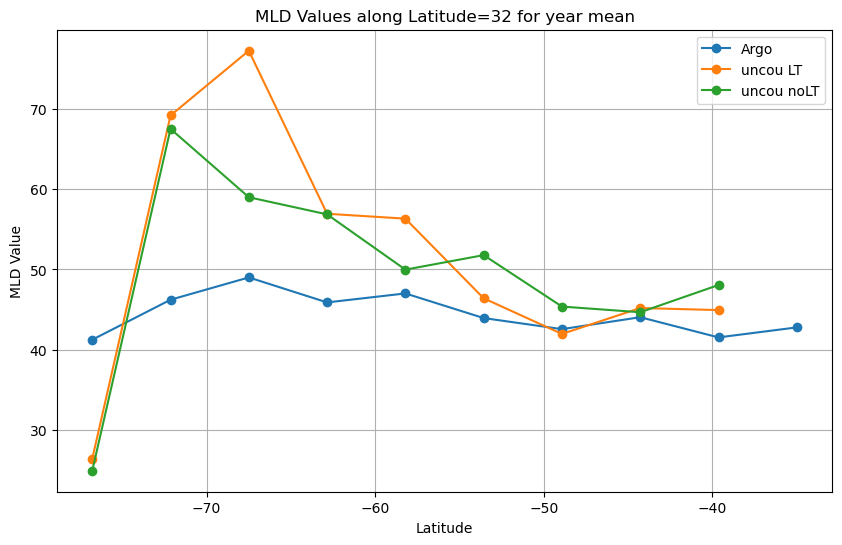

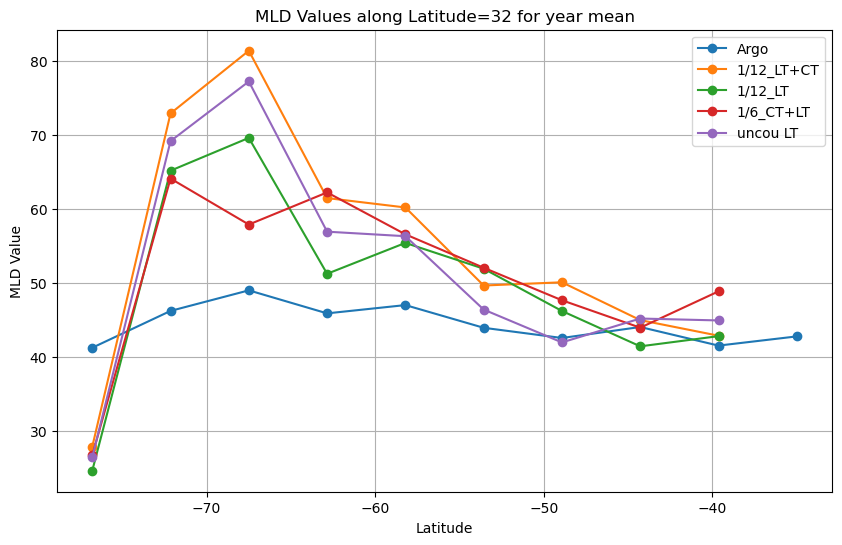

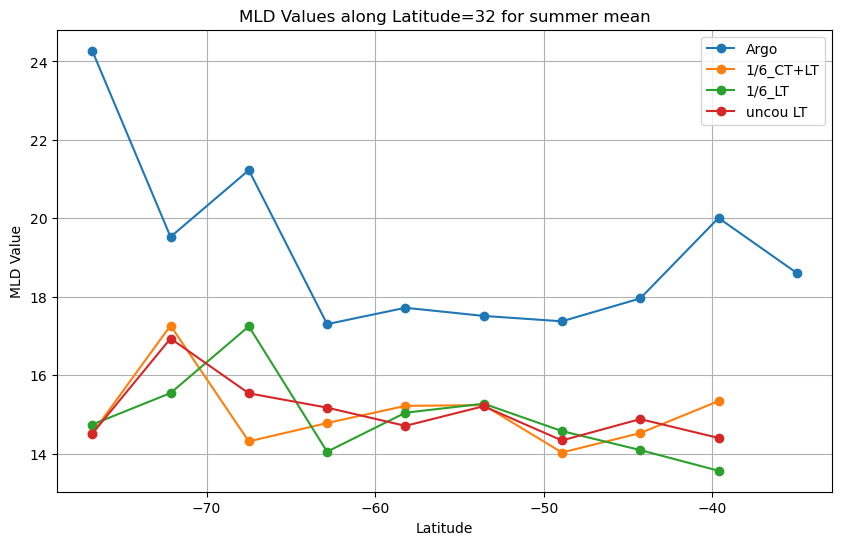

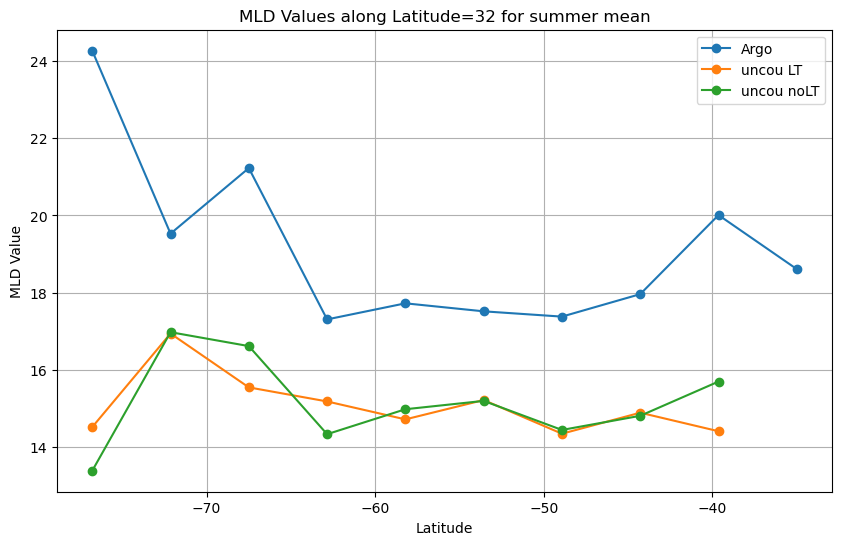

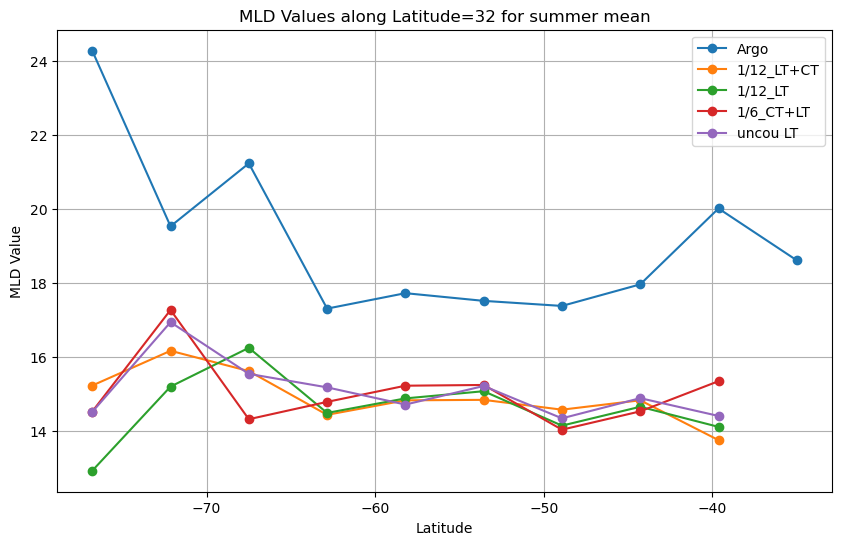

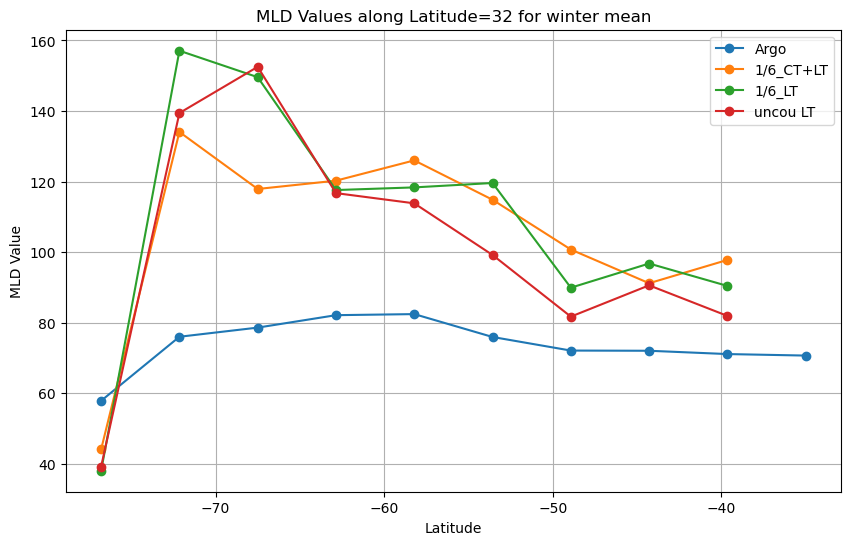

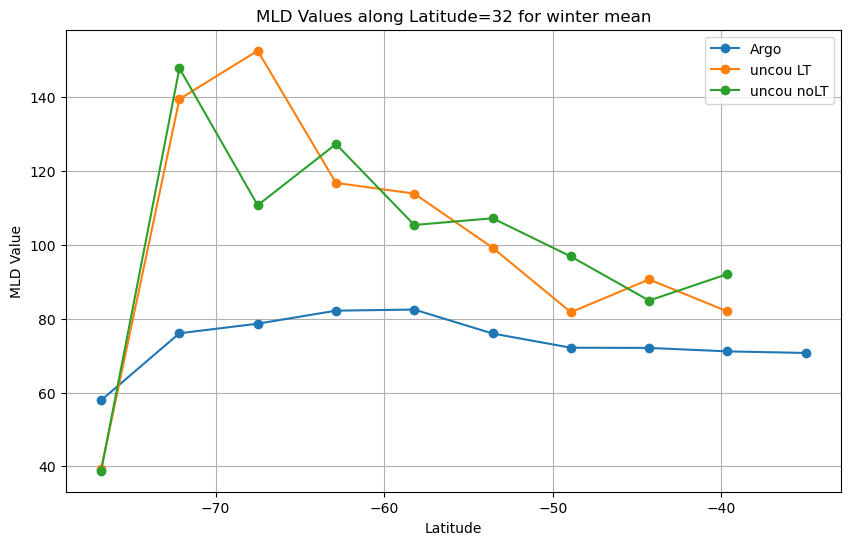

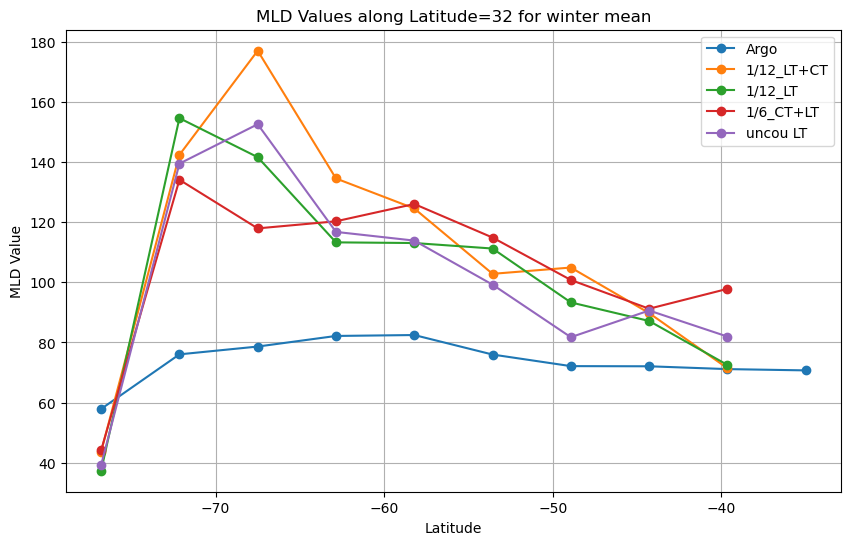

In [80]:

lat_slice=32
def plot_mld_for_points_ave(datasets_list, points,time_name,lat_slice):
    # Extract longitude and latitude separately
    interp_lon = points[:, 0]  # Longitudes
    interp_lat = points[:, 1]  # Latitudes
    
    # Loop over time steps
    
    plt.figure(figsize=(10, 6))
    
    for dataset in datasets_list:
        # Interpolate MLD values at given points
        mld = dataset
        interpolated_values = np.array([
            mld.interp(xh=lon, yh=lat, method="linear").values
            for lon, lat in zip(interp_lon, interp_lat)
        ])
        # Scatter plot of interpolated values
        plt.plot(interp_lon, interpolated_values, label=str(dataset.name), marker='o')
    
    # Customize the plot
    plt.xlabel('Latitude')
    plt.ylabel('MLD Value')
    plt.title(f'MLD Values along Latitude={lat_slice} for {time_name}')
    plt.legend()  # Add legend to differentiate datasets
    plt.grid(True)
    plt.show()
points = np.array([(lon, lat_slice) for lon in np.linspace(-100, -35, 15)])
# Define datasets list
# datasets_list = [MLD_argo_ave, MLD_6_all_ave, MLD_6_wave_ave, MLD_uncou_ave, 
#                  MLD_uncou_LAfalse_ave, MLD_12_all_ave, MLD_12_wave_ave]
datasets_list1 = [MLD_argo_ave, MLD_6_all_ave, MLD_6_wave_ave, MLD_uncou_ave]
datasets_list2= [MLD_argo_ave, MLD_uncou_ave,MLD_uncou_LAfalse_ave]
datasets_list3 = [MLD_argo_ave, MLD_12_all_ave, MLD_12_wave_ave, MLD_6_all_ave,MLD_uncou_ave]
plot_mld_for_points_ave(datasets_list1, points,'year mean',lat_slice)
plot_mld_for_points_ave(datasets_list2, points,'year mean',lat_slice)
plot_mld_for_points_ave(datasets_list3, points,'year mean',lat_slice)
datasets_list1 = [S_argo, S_6_all, S_6_wave, S_uncou]
datasets_list2= [S_argo, S_uncou,S_uncou_LAfalse]
datasets_list3 = [S_argo, S_12_all, S_12_wave, S_6_all,S_uncou]
plot_mld_for_points_ave(datasets_list1, points,'summer mean',lat_slice)
plot_mld_for_points_ave(datasets_list2, points,'summer mean',lat_slice)
plot_mld_for_points_ave(datasets_list3, points,'summer mean',lat_slice)
datasets_list1 = [W_argo, W_6_all, W_6_wave, W_uncou]
datasets_list2= [W_argo, W_uncou,W_uncou_LAfalse]
datasets_list3 = [W_argo, W_12_all, W_12_wave, W_6_all,W_uncou]
plot_mld_for_points_ave(datasets_list1, points,'winter mean',lat_slice)
plot_mld_for_points_ave(datasets_list2, points,'winter mean',lat_slice)
plot_mld_for_points_ave(datasets_list3, points,'winter mean',lat_slice)

In [6]:
model_grid_x

<xarray.IndexVariable 'xh' (xh: 775)>
array([-98.      , -97.920013, -97.839996, ..., -36.23999 , -36.160004,
       -36.079987])
Attributes:
    units:      degrees_east
    long_name:  h point nominal longitude
    axis:       X

In [7]:
model_grid_y

<xarray.IndexVariable 'yh' (yh: 845)>
array([ 5.272542,  5.352199,  5.431845, ..., 51.895451, 51.914215, 51.932964])
Attributes:
    units:      degrees_north
    long_name:  h point nominal latitude
    axis:       Y

In [11]:
argo_lat

<xarray.IndexVariable 'Lat' (Lat: 86)>
array([-85., -83., -81., -79., -77., -75., -73., -71., -69., -67., -65., -63.,
       -61., -59., -57., -55., -53., -51., -49., -47., -45., -43., -41., -39.,
       -37., -35., -33., -31., -29., -27., -25., -23., -21., -19., -17., -15.,
       -13., -11.,  -9.,  -7.,  -5.,  -3.,  -1.,   1.,   3.,   5.,   7.,   9.,
        11.,  13.,  15.,  17.,  19.,  21.,  23.,  25.,  27.,  29.,  31.,  33.,
        35.,  37.,  39.,  41.,  43.,  45.,  47.,  49.,  51.,  53.,  55.,  57.,
        59.,  61.,  63.,  65.,  67.,  69.,  71.,  73.,  75.,  77.,  79.,  81.,
        83.,  85.])

In [23]:
argo_lon

<xarray.Variable (Lon: 180)>
array([   1.,    3.,    5.,    7.,    9.,   11.,   13.,   15.,   17.,
         19.,   21.,   23.,   25.,   27.,   29.,   31.,   33.,   35.,
         37.,   39.,   41.,   43.,   45.,   47.,   49.,   51.,   53.,
         55.,   57.,   59.,   61.,   63.,   65.,   67.,   69.,   71.,
         73.,   75.,   77.,   79.,   81.,   83.,   85.,   87.,   89.,
         91.,   93.,   95.,   97.,   99.,  101.,  103.,  105.,  107.,
        109.,  111.,  113.,  115.,  117.,  119.,  121.,  123.,  125.,
        127.,  129.,  131.,  133.,  135.,  137.,  139.,  141.,  143.,
        145.,  147.,  149.,  151.,  153.,  155.,  157.,  159.,  161.,
        163.,  165.,  167.,  169.,  171.,  173.,  175.,  177.,  179.,
       -179., -177., -175., -173., -171., -169., -167., -165., -163.,
       -161., -159., -157., -155., -153., -151., -149., -147., -145.,
       -143., -141., -139., -137., -135., -133., -131., -129., -127.,
       -125., -123., -121., -119., -117., -115., -113., -111., -109.,
       -107., -105., -103., -101.,  -99.,  -97.,  -95.,  -93.,  -91.,
        -89.,  -87.,  -85.,  -83.,  -81.,  -79.,  -77.,  -75.,  -73.,
        -71.,  -69.,  -67.,  -65.,  -63.,  -61.,  -59.,  -57.,  -55.,
        -53.,  -51.,  -49.,  -47.,  -45.,  -43.,  -41.,  -39.,  -37.,
        -35.,  -33.,  -31.,  -29.,  -27.,  -25.,  -23.,  -21.,  -19.,
        -17.,  -15.,  -13.,  -11.,   -9.,   -7.,   -5.,   -3.,   -1.])

In [25]:
MLD_uncou

<xarray.Dataset>
Dimensions:           (xh: 775, yh: 845, time: 366, nv: 2, xq: 776, yq: 846)
Coordinates:
  * xh                (xh) float64 -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh                (yh) float64 5.273 5.352 5.432 5.511 ... 51.9 51.91 51.93
  * time              (time) datetime64[ns] 2004-01-01T12:00:00 ... 2004-12-3...
  * nv                (nv) float64 1.0 2.0
  * xq                (xq) float64 -98.04 -97.96 -97.88 ... -36.2 -36.12 -36.04
  * yq                (yq) float64 5.233 5.312 5.392 5.472 ... 51.9 51.92 51.94
Data variables: (12/33)
    ssh               (time, yh, xh) float32 ...
    sshmin            (time, yh, xh) float32 ...
    sshmax            (time, yh, xh) float32 ...
    tos               (time, yh, xh) float32 ...
    tosmin            (time, yh, xh) float32 ...
    tosmax            (time, yh, xh) float32 ...
    ...                ...
    LA_MOD            (time, yh, xh) float32 ...
    MSTAR_LT          (time, yh, xh) float32 ...
    average_T1        (time) datetime64[ns] ...
    average_T2        (time) datetime64[ns] ...
    average_DT        (time) timedelta64[ns] ...
    time_bnds         (time, nv) datetime64[ns] ...
Attributes:
    NumFilesInSet:     1
    title:             CEFI_NWA12_COBALT_V1
    associated_files:  areacello: 20040101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A